In [6]:
%matplotlib inline

import os
import sys
import scipy
import pandas as pd

import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from functools import partial

import gpflow

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from tutorial_utils import *

sns.set_style('darkgrid')

%load_ext line_profiler

# Maximum Likelihood (1D)

To start let's consider an very simple toy problem. Let's say we have some measurements from a normal distribution with unknown mean and variance,
$$
\mathbf{y} \sim \mathcal{N}\left(\mu, \sigma^2\right)
$$

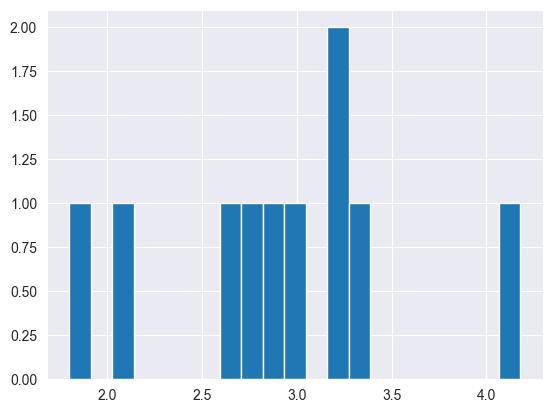

In [7]:
np.random.seed(2012)
mu = np.pi
sigma = np.log(2)
actual_dist = scipy.stats.norm(loc=mu, scale=sigma)
y_train = actual_dist.rvs(size=10)
_ = plt.hist(y_train, bins=21)

now we'd like to estimate $\hat{\mu}$ and $\hat{\sigma}$ which "best" describe the data. One way would be to propose a value for $\hat{\mu}$ and $\hat{\sigma}$,

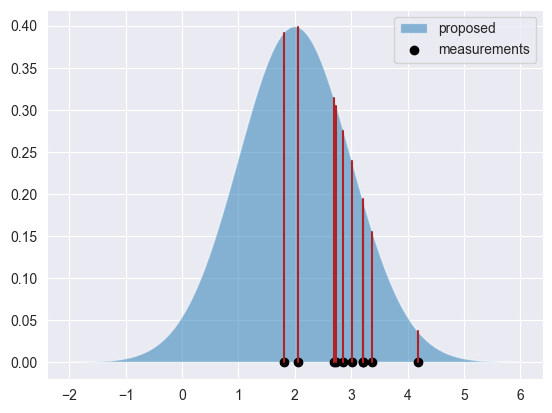

In [8]:
proposed_dist = scipy.stats.norm(loc=2., scale=1.)
xs = np.linspace(-2., 6., 101)
plt.fill(xs, proposed_dist.pdf(xs), label="proposed", alpha=0.5)
plt.scatter(y_train, np.zeros(y_train.size), color='black', label="measurements")
for y_i in y_train:
    plt.plot([y_i, y_i], [0, proposed_dist.pdf(y_i)], color='firebrick')
_ = plt.legend()

Here the red lines show the probability density (PDF) according to the proposed distribution (in blue) for the data points. You can then ask for the likelihood one of the data points came from the proposed distribution. Likelihood basically just means the probability density. We can evaluate the PDF for a single observation, $y_i$,
$$
p(y_i; \hat{\mu}, \hat{\sigma}) = \frac{1}{\hat{\sigma}\sqrt{2\pi}} \mbox{exp}\left[-\frac{(y_i - \hat{\mu})^2}{2 \hat{\sigma}^2}\right]
$$
Since $y_i$ and $y_j$ are independent, the probability that both $y_i$ _and_ $y_j$ came from the distribution you multiply,
$$
p(y_i, y_j) = p(y_i) p(y_j)
$$
Repeating for all the data gives us,
$$
p(y_0, \ldots, y_n; \hat{\mu}, \hat{\sigma}) = \prod_i^n \frac{1}{\hat{\sigma}\sqrt{2\pi}} \mbox{exp}\left[-\frac{(y_i - \hat{\mu})^2}{2 \hat{\sigma}^2}\right]
$$
This involves evaluating the probability density at each data point and then taking the product of them all. Let's compute that below. Note that the `scipy` distributions have a `dist.pdf()` method, so no need to implement that your self.

In [9]:
def compute_independent_likelihood(dist, data):
    # YOUR CODE HERE
    # pdfs = 
    # likelihood = 

    pdfs = dist.pdf(data)

    likelihood = 1;
    for i in range( 0, len(pdfs) ):
        likelihood = likelihood*pdfs[i]
    
    return likelihood # (scalar)

#TEST_COMPUTE_INDEPENDENT_LIKELIHOOD(compute_independent_likelihood)

and then take the product to get the overall probability the data,

In [10]:
compute_independent_likelihood(proposed_dist, y_train)

2.076814756767436e-07

Notice that the likelihood is _VERY_ small. Check out what happens when we have even more data,

In [11]:
# the dist.rvs(n) method will sample n random variables from the distribution
compute_independent_likelihood(actual_dist, actual_dist.rvs(size=1000))

0.0

Notice that we drew samples from a distribution, then asked for the likelihood those samples came from the actual distribution ... yet we still got a zero! The problem is that the likelihood of each data point is smaller than 1, so the product of lots of small numbers converges to zero. Now check this out,

In [12]:
tight_dist = scipy.stats.norm(loc=0., scale=1e-6)
compute_independent_likelihood(tight_dist, tight_dist.rvs(size=1000))

/var/folders/l9/7yp77dt150l579ybtm5pxrp80000gn/T/ipykernel_51696/1867867062.py:10: RuntimeWarning: overflow encountered in scalar multiply
  likelihood = likelihood*pdfs[i]


inf

This time we got infinite likelihood! In this case, because the scale ($\sigma$) of the distribution was so small, the density actually takes on really large values, here's the peak probability density for the tight distribution,

In [13]:
tight_dist.pdf(0)

398942.2804014327

While a distribution with a larger scale return density values which are smaller,

In [14]:
wide_dist = scipy.stats.norm(loc=0., scale=1000)
wide_dist.pdf(wide_dist.mean())

0.0003989422804014327

The point here is that directly working with likelihood means multiplying lots of values together and those values could be large or small which can quickly lead to numerically zero or numerically infinite likelihood computations. to alleviate this problem we can look at log likelihoods,
$$
\begin{align}
\mbox{log}[p(y)] &= \mbox{log}\left[\prod_i^n \frac{1}{\hat{\sigma}\sqrt{2\pi}} \mbox{exp}\left(-\frac{(y_i - \hat{\mu})^2}{2 \hat{\sigma}^2}\right)\right] \\
&= \sum_i^n \mbox{log}\left[\frac{1}{\hat{\sigma}\sqrt{2\pi}} \mbox{exp}\left(-\frac{(y_i - \hat{\mu})^2}{2 \hat{\sigma}^2}\right)\right] \\
&= - n \mbox{log}[\hat{\sigma}] - \frac{n}{2} \mbox{log}[2 \pi] - \sum_i^n \frac{(y_i - \hat{\mu})^2}{2 \hat{\sigma}^2}
\end{align}
$$
Let's try implementing that, feel free to do it from scratch, or `scipy` also has a helper for the log PDF, `dist.logpdf()`

In [17]:
def compute_independent_log_likelihood(dist, data):
    # YOUR CODE HERE
    log_pdfs = dist.logpdf(data)
    log_likelihood = 1;
    for i in range( 0, len(log_pdfs) ):
        log_likelihood = log_likelihood*log_pdfs[i]
    return log_likelihood # (scalar)


In [18]:
compute_independent_log_likelihood(tight_dist, tight_dist.rvs(1000))

/var/folders/l9/7yp77dt150l579ybtm5pxrp80000gn/T/ipykernel_51696/1213494916.py:6: RuntimeWarning: overflow encountered in scalar multiply
  log_likelihood = log_likelihood*log_pdfs[i]


inf

In [19]:
compute_independent_log_likelihood(wide_dist, wide_dist.rvs(1000))

/var/folders/l9/7yp77dt150l579ybtm5pxrp80000gn/T/ipykernel_51696/1213494916.py:6: RuntimeWarning: overflow encountered in scalar multiply
  log_likelihood = log_likelihood*log_pdfs[i]


inf

The two likelihood computations are very different magnitudes, but by taking the log of the likelihood we have more numerically stable results.

Now that we can compute the likelihood that the data came from a model with given parameters, we can try to find the parameters which maximize that likelihood. `scipy` also has an `optimize` package which provides some methods we can use to find the argument which minimize a function. The interface requires an objective function that takes a numpy array as a single argument and returns a scalar.
```
def objective_to_minimize(x):
    return scalar
```
After which you can use,
```
arguments_which_minimize = scipy.optimize.minimize(objective_to_minimize).x
```
which, as the name suggests, will _minimize_ the function. If you want to maximize the function you'll need your objective function to return the negative of your actual objective,
```
def objective_to_minimize(x):
    return -objective_to_maximize(x)
```
This is why it's common to talk about the negative log likelihood (NLL), not the log likelihood. Let's write a function which takes a mean and standard deviation as input and returns the negative log likelihood that the data came from the proposed distribution,

In [ ]:
def compute_independent_negative_log_likelihood(params, ys):
    mu, sigma = params
    # YOUR CODE HERE
    #
    # first, build a scipy distribution from the parameters
    # distribution =
    #
    # then use it to compute the likelihood
    # log_likelihood = 
    #
    return -log_likelihood

TEST_COMPUTE_INDEPENDENT_NEGATIVE_LOG_LIKELIHOOD(compute_independent_negative_log_likelihood)

In [ ]:
mle_mu, mle_sigma = scipy.optimize.minimize(compute_independent_negative_log_likelihood,
                                            x0=[1., 1.],
                                            args=(y_train,),
                                            bounds=[(1e-6, 100), (1e-6, 100)]).x
print(f"mean -- actual: {actual_dist.mean():.3f}, MLE estimate: {mle_mu:.3f}")
print(f"std  -- actual: {actual_dist.std():.3f}, MLE estimate: {mle_sigma:.3f}")

Not bad, the maximum likelihood estimate of the mean and standard deviation are pretty close to the true values, particularly given the small sample size. Here's what we'd get with a much larger dataset,

In [ ]:
large_mle_mu, large_mle_sigma = scipy.optimize.minimize(compute_independent_negative_log_likelihood,
                                            x0=[1., 1.],
                                            args=(actual_dist.rvs(size=10000),),
                                            bounds=[(1e-6, 100), (1e-6, 100)]).x
print(f"mean -- actual: {actual_dist.mean():.3f}, MLE estimate: {large_mle_mu:.3f}")
print(f"std  -- actual: {actual_dist.std():.3f}, MLE estimate: {large_mle_sigma:.3f}")

Fun fact, instead of building a log likelihood function and doing a computationally intense round of numerical optimization to learn the maximum likelihood estimates of the mean and standard devation we could have just computed the mean and standard deviation of the sample data!

In [ ]:
print(np.mean(y_train), mle_mu)

In [ ]:
print(np.std(y_train), mle_sigma)

For normal distributions moment matching (setting the mean and variance to the sample mean and variance) is equivalent to maximum likelihood estimation! So in this toy problem, solving from the params that maximize likelihood is overkill, but this concept using optimization routines to find the parameters that maximize the likelihood is more generally useful.

# Maximum Likelihood (Gaussian Processes)

You may remember from the first tutorial, we defined a GP with a squared exponential covariance, and then solved for the parameters ($\sigma_{se}$, $\ell$ and $\sigma_{\epsilon}$) which maximized the likelihood of the data. That implementation was _very_ similar to the 1D case we just implemented, but let's generalize it here. In the 1D example, we picked values, $\hat{\mu}$ and $\hat{\sigma}$, and proposed a distribution,
$$
y_i = \mathcal{N}\left(\hat{\mu}, \hat{\sigma}^2\right)
$$
then maximized the likelihood that $y = \{y_0, \ldots, y_n\}$ came from that distribution.

When we build a Gaussian process we start with a general form for a covariance function, $c(x, x')$. That covariance function might have its own hyper parameters, $\theta$. This is often written $c(x, x'; \theta)$ to indicate that $x$ and $x'$ are the arguments, while $\theta$ are hyper parameters which change the behavior of $c$. Take the squared exponential as an example, that function can be written,
$$
c(x_i, x_j; \sigma, \ell) = \sigma^2 \mbox{exp}\left(-\frac{\left|x_i - x_j\right|^2}{\ell^2}\right).
$$
Let's setup an optimization problem which let's us solve for the maximum likelihood hyper parameters. Much like the 1D problem we'll need to write a function which takes arbitrary values for $\sigma$ and $\ell$ and returns the likelihood that our data came from the proposed distribution. First, the proposed distribution for a given set of parameters,
$$
\mathbf{y} \sim \mathcal{N}\left(0, \Sigma_{yy}(\sigma, \ell) + \sigma_{\epsilon}^2 I\right)
$$
Notice that we've assumed the mean is zero again, $\Sigma_{yy}$ depends on the hyper parameters $\sigma$ and $\ell$, and there's actually a third hyper parameter $\sigma_{\epsilon}$ which describes the measurement noise. For simplicity, let's drop the subscripts and call $\Sigma$ the resulting covariance matrix for a given set of hyper parameters,
$$
\Sigma = \Sigma_{yy}(\sigma, \ell) + \sigma_{\epsilon}^2 I
$$
giving us,
$$
\mathbf{y} \sim \mathcal{N}\left(0, \Sigma\right)
$$
we now need to compute the likelihood that actual measurements $y$ came from the proposed distribution.

At the end of the notebook I added a section where I describe a way to intuitively get from the definition of likelihood for independent normal random variables to correlated multivariate normal variables, you could take a look at that ... or just [look on wikipedia](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Likelihood_function).

The multivariate log likelihood function is,
$$
\begin{align}
\mbox{log}(p(y)) &= \mbox{log}\left(|\Sigma|^{-1/2} (2\pi)^{-n/2} \mbox{exp}\left[-\frac{y^T \Sigma^{-1} y}{2}\right]\right) \\
& = -\frac{1}{2} \mbox{log}\left(|\Sigma|\right) - \frac{n}{2} \mbox{log}(2\pi) - \frac{y^T \Sigma^{-1} y}{2}
\end{align}
$$
There are a lot of different ways you could do this, but some tips you might find useful are:
- `np.linalg.slogdet(A)`. which returns a pair `sign, log_det`. In this case the `sign` should always be positive, so you probably only care about the second return value: `log_det = np.linalg.slogdet(A)[1]`
- `scipy.stats.multivariate_normal.logpdf`. this one is definitely cheating ... but if you're short on time go for it!

In [ ]:
# compute_mvn_log_likelihood(S, y)
#
#   Compute the log likelihood for a sample y, from a
#   multivariate normal (mvn) distribution with covariance S
#   and mean assumed zero.
def compute_mvn_log_likelihood(S, y):
    # YOUR CODE HERE
    #
    # log_det_term =
    # constant_term = 
    # squared_error_term = 
    # log_likelihood = 
    return log_likelihood

TEST_COMPUTE_MVN_LOG_LIKELIHOOD(compute_mvn_log_likelihood)

Let's recreate the one dimensional Gaussian process example from the first tutorial,

In [ ]:
np.random.seed(2012)
N = 101
X_train = np.random.uniform(LOW, HIGH, size=N)
y_train = truth(X_train) + MEAS_NOISE * np.random.normal(size=N)
X_gridded = np.linspace(LOWEST, HIGHEST, 101)

plot_truth(X_gridded)
plot_measurements(X_train, y_train)

We can now propose different measurement noise, $\sigma_{\epsilon}^2$, length scales, $\ell$, and variances, $\sigma^2$ to get a sense of how sensitive the likelihood is to the hyper parameters. First, let's fix the variance and measurement noise,

In [ ]:
ells = np.linspace(0.5, 5, 51)

def eval(ell, sigma, meas_noise=MEAS_NOISE):
    cov = example_squared_exponential(X_train, X_train, ell=ell, sigma=sigma)
    cov += np.square(meas_noise) * np.eye(y_train.size)
    return compute_mvn_log_likelihood(cov, y_train)

log_likelihoods = np.vectorize(eval)(ells, 1.)

plt.plot(ells, log_likelihoods)
plt.xlabel("Length Scale")
plt.ylabel("Log Likelihood")

With the variances held fixed, we see there's a strong dependence on the length scale. But the likelhood also depends strong on the $\sigma$ we pick,

In [ ]:
sigmas = np.linspace(0.5, 5, 51)
log_likelihoods = np.vectorize(eval)(2., sigmas)

plt.plot(sigmas, log_likelihoods)
plt.xlabel("sigma")
plt.ylabel("Log Likelihood")

We can plot both the likelihood with respect to both of these variables as a surface,

In [ ]:
grid_ells, grid_sigmas = np.meshgrid(ells, sigmas)

log_likelihoods = np.vectorize(eval)(grid_ells, grid_sigmas)

# Create a 3D plot
fig = plt.figure(figsize=(24, 8))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(grid_ells, grid_sigmas, log_likelihoods)
ax.set_xlabel("Length Scale")
ax.set_ylabel("Sigma")

ax = fig.add_subplot(122)
plt.pcolor(grid_ells, grid_sigmas, log_likelihoods)
ax.set_xlabel("Length Scale")
ax.set_ylabel("Sigma")
plt.colorbar()

We could just look at these plots and get a pretty good idea of which values to use, but then we'd be ignoring the third variable. Instead we can use the same numerical optimization technique from the univariate case. To do so we need our objective function. We'll assume we're using a simple GP with a squared exponential covariance, no need to re-implement the covariance function, feel free to use `example_squared_exponential(x_i, x_j, sigma, ell)`,

In [ ]:
def compute_sqr_exp_negative_log_likelihood(params, X, y):
    sigma, ell, meas_noise = params
    # Compute S = S_yy + meas_noise^2 I
    # S =
    # log_likelihood =    
    return -log_likelihood

TEST_COMPUTE_SQR_EXP_NLL(compute_sqr_exp_negative_log_likelihood)

In [ ]:
x0 = np.ones(3) # initialize parameters with something reasonable
bounds = [(1e-6, 100)] * 3 # we need to keep the hyper-parameters positive.
mle_params = scipy.optimize.minimize(compute_sqr_exp_negative_log_likelihood,
                                     x0=x0, method="L-BFGS-B",
                                     args=(X_train, y_train),
                                     bounds=bounds)
mle_params = dict(zip(["sigma", "ell", "noise"], mle_params.x))
print(mle_params)

Just to make sure, we can show our maximum likelihood estimates on top of the likelihood surface:

In [ ]:
ax = fig.add_subplot(122)

log_likelihoods = np.vectorize(eval)(grid_ells, grid_sigmas, mle_params["noise"])
plt.pcolor(grid_ells, grid_sigmas, log_likelihoods)
plt.colorbar()
plt.xlabel("Length Scale")
plt.ylabel("Sigma")
plt.scatter(mle_params["ell"], mle_params["sigma"],
            s=500, color="steelblue", marker="*")
plt.text(mle_params["ell"], mle_params["sigma"] + 0.2, "MLE",
         fontsize="x-large", ha="center")

At this point we've implemented a lot of the math you'd find in a typical Gaussian process package. Don't believe me? We can compare our MLE estimated parameters to those estimated by `gpflow`.

In [ ]:
X_gpflow = X_train[:, None].copy()
y_gpflow = y_train[:, None].copy()
model = gpflow.models.GPR(
    (X_train[:, None], y_train[:, None]),
    kernel=gpflow.kernels.SquaredExponential(),
)
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)

gpflow_params = {
    "sigma": np.sqrt(model.kernel.variance.numpy()),
    "ell": model.kernel.lengthscales.numpy(),
    "noise": np.sqrt(model.likelihood.variance.numpy())
}

pd.DataFrame({"ours": mle_params, "gpflow": gpflow_params})

We had to convert from variance to standard deviation, but the hyper parameters are equivalent!



A lot of the remaining complexity in packages (including `albatross`) consists of generalizations to help a user compose covariance functions, keep track of all the hyper parameters, and provide the building blocks which allow users to write custom objective functions.

In [ ]:
mle_cov_func = partial(example_squared_exponential,
                       sigma=mle_params["sigma"], ell=mle_params["ell"])

mle_mean, mle_cov = example_fit_and_predict(mle_cov_func, X_train, y_train,
                                            X_gridded, meas_noise=mle_params["noise"])

gpflow_mean, gpflow_var = model.predict_f(X_gridded[:, None])
fig, axes = plt.subplots(1, 2, figsize=(24, 8))
axes[0].set_title("Our Impementation")
plot_spread(X_gridded, mle_mean, np.sqrt(np.diag(mle_cov)), ax=axes[0])
axes[1].set_title("gpflow")
plot_spread(X_gridded, gpflow_mean, np.sqrt(gpflow_var), ax=axes[1])

# Appendix:

### Intuition Behind Multivariate Normal Likelihoods

Understanding this section isn't entirely neccesary, and the math is a little hand wavey, but it might help build some intuition around the likelihood of a multivariate normal distribution,
$$
\mathbf{y} \sim \mathcal{N}\left(0, \Sigma\right)
$$
it might be tempting to do the same thing we did in one dimension and first compute $p(y_i)$ using the diagonal element of $\Sigma_{ii}$ for each measurement, then form $p(y) = \prod_i p(y_i)$, but that doesn't work anymore! Simply multiplying marginal likelihoods like that assumes each $y_i$ is independent of all the others, but because we assume $\Sigma$ is dense we now have correlated measurements. In the first tutorial we started with independent random variables,
$$
\mathbf{z} \sim \mathcal{N}\left(0, I\right)
$$
and correlated them,
$$
\begin{align}
L \mathbf{z} &\sim \mathcal{N}\left(0, L L^T\right) \\
& \sim \mathcal{N}\left(0, \Sigma \right)
\end{align}
$$
using the cholesky ($L$ such that $L L^T = \Sigma$). We can actually reverse that process to de-correlate our measurements,
$$
\begin{align}
L^{-1} \mathbf{y} &\sim L^{-1} \mathcal{N}\left(0, \Sigma\right) \\
&\sim \mathcal{N}\left(0, L^{-1} \Sigma L^{-T}\right) \\
&\sim \mathcal{N}\left(0, I\right) \\
\end{align}
$$
So if we're given measurements $y$ we can decorrelate them to get $z = L^{-1} y$ and can then focus on computing the likelihood for $z = \{z_0, \ldots, z_n\}$ standard normal variables. For that we'll use $f(z_i)$ to mean the probability density function for, $z_i \sim \mathcal{N}(0, 1)$, stanard normal variables,
$$
\begin{align}
f(z_0, \ldots, z_n) &= \prod_i^n f(z_i) \\
& = \prod_i^n \frac{1}{\sqrt{2\pi}} \mbox{exp}\left[-\frac{z_i^2}{2}\right] \\
& = \frac{1}{\sqrt{2\pi}^n} \mbox{exp}\left[-\sum_i\frac{z_i^2}{2}\right] \\
& = (2\pi)^{-n/2} \mbox{exp}\left[-\frac{z^T z}{2}\right] \\
\end{align}
$$
So if $L^{-1} \mathbf{y} \sim \mathcal{N}(0, I)$, then maybe,
$$
\begin{align}
p(y) &= f\left(L^{-1} y\right) \\
&= (2\pi)^{-n/2} \mbox{exp}\left[-\frac{y^T L^{-T} L^{-1} y}{2}\right] \\
&= (2\pi)^{-n/2} \mbox{exp}\left[-\frac{y^T \Sigma^{-1} y}{2}\right] \\
\end{align}
$$
This is _almost_ right (but is NOT true!) The integral of any probability density function over the whole domain needs to equal one and when we multiplied $y$ by $L^{-1}$ we will have changed the scale. We can measure how much we will have changed the scale by computing the determinant (see an [explanation here](https://en.wikipedia.org/wiki/Determinant#Geometric_meaning)). So to make this conversion from a decorrelated probability density function to a correlated equivalent we need to also multiply by the determinant, $|L^{-1}|$:
$$
\begin{align}
p(y) &= |L^{-1}| (2\pi)^{-n/2} \mbox{exp}\left[-\frac{y^T \Sigma^{-1} y}{2}\right] \\
p(y) &= |L|^{-1} (2\pi)^{-n/2} \mbox{exp}\left[-\frac{y^T \Sigma^{-1} y}{2}\right] \\
&= |\Sigma|^{-1/2} (2\pi)^{-n/2} \mbox{exp}\left[-\frac{y^T \Sigma^{-1} y}{2}\right]
\end{align}
$$
Where those last few steps include some identities of determinants: $|A B| = |A||B|$ and $|A^{-1}| = |A|^{-1}$.
The takeaway: computing the likelihood for multivariate normal variables is the same as decorrelating, then computing (and rescaling) the likelihood for decorrelated normal variables.